In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


The following is to read the csv file while has the Toronto Neighbourhood information. The csv file could be constructed easily by copy paste.

In [2]:
df = pd.read_csv('Toronto_Dataset.csv', names=["Postcode", "Borough", "Neighbourhood"])
df.head(10)

Postcode           Borough     Neighbourhood
0      M1A      Not assigned      Not assigned
1      M2A      Not assigned      Not assigned
2      M3A        North York         Parkwoods
3      M4A        North York  Victoria Village
4      M5A  Downtown Toronto      Harbourfront
5      M5A  Downtown Toronto       Regent Park
6      M6A        North York  Lawrence Heights
7      M6A        North York    Lawrence Manor
8      M7A      Queen's Park      Not assigned
9      M8A      Not assigned      Not assigned

In [3]:
df = df[df['Borough'] != 'Not assigned']
df.loc[df['Neighbourhood'] == 'Not assigned', 'Neighbourhood'] = df.loc[df['Neighbourhood'] == 'Not assigned', 'Borough']

In [4]:
df.head(10)
df.shape

(211, 3)

In [5]:
df_new = df.groupby(df['Postcode']).aggregate({'Borough': 'first', 'Neighbourhood': lambda x: ', '.join(x)})

In [6]:
df_new.head(5)

Borough                           Neighbourhood
Postcode                                                     
M1B       Scarborough                          Rouge, Malvern
M1C       Scarborough  Highland Creek, Rouge Hill, Port Union
M1E       Scarborough       Guildwood, Morningside, West Hill
M1G       Scarborough                                  Woburn
M1H       Scarborough                               Cedarbrae

Since the request to visit Google API is denied, I have download the csv file which has the information for latidude and longtitude of each neighbourhood.

In [7]:
df_latlng = pd.read_csv('https://ibm.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv')

In [8]:
df_latlng.head()

Postal Code   Latitude  Longitude
0         M1B  43.806686 -79.194353
1         M1C  43.784535 -79.160497
2         M1E  43.763573 -79.188711
3         M1G  43.770992 -79.216917
4         M1H  43.773136 -79.239476

In [9]:
df_latlng.set_index('Postal Code')
df_latlng.head()

Postal Code   Latitude  Longitude
0         M1B  43.806686 -79.194353
1         M1C  43.784535 -79.160497
2         M1E  43.763573 -79.188711
3         M1G  43.770992 -79.216917
4         M1H  43.773136 -79.239476

Merge the Datasets

In [10]:
df_new = df_new.join(df_latlng.set_index('Postal Code'))
df_new.head()

Borough                           Neighbourhood   Latitude  \
Postcode                                                                   
M1B       Scarborough                          Rouge, Malvern  43.806686   
M1C       Scarborough  Highland Creek, Rouge Hill, Port Union  43.784535   
M1E       Scarborough       Guildwood, Morningside, West Hill  43.763573   
M1G       Scarborough                                  Woburn  43.770992   
M1H       Scarborough                               Cedarbrae  43.773136   

          Longitude  
Postcode             
M1B      -79.194353  
M1C      -79.160497  
M1E      -79.188711  
M1G      -79.216917  
M1H      -79.239476

In [11]:
df_new.reset_index(inplace = True)
df_new.head()

Postcode      Borough                           Neighbourhood   Latitude  \
0      M1B  Scarborough                          Rouge, Malvern  43.806686   
1      M1C  Scarborough  Highland Creek, Rouge Hill, Port Union  43.784535   
2      M1E  Scarborough       Guildwood, Morningside, West Hill  43.763573   
3      M1G  Scarborough                                  Woburn  43.770992   
4      M1H  Scarborough                               Cedarbrae  43.773136   

   Longitude  
0 -79.194353  
1 -79.160497  
2 -79.188711  
3 -79.216917  
4 -79.239476

In [12]:
df_new_clustering = df_new.drop(['Postcode','Neighbourhood','Borough'], 1)
df_new_clustering.head()

Latitude  Longitude
0  43.806686 -79.194353
1  43.784535 -79.160497
2  43.763573 -79.188711
3  43.770992 -79.216917
4  43.773136 -79.239476

Conduct K means clustering with longtitude and latitude

In [13]:
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_new_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4,
       4, 4, 4, 2, 2, 2, 4, 4, 4, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3,
       3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 1, 3, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [14]:
df_new.insert(0, 'Cluster Labels', kmeans.labels_)

In [15]:
df_new.head()

Cluster Labels Postcode      Borough  \
0               0      M1B  Scarborough   
1               0      M1C  Scarborough   
2               0      M1E  Scarborough   
3               0      M1G  Scarborough   
4               0      M1H  Scarborough   

                            Neighbourhood   Latitude  Longitude  
0                          Rouge, Malvern  43.806686 -79.194353  
1  Highland Creek, Rouge Hill, Port Union  43.784535 -79.160497  
2       Guildwood, Morningside, West Hill  43.763573 -79.188711  
3                                  Woburn  43.770992 -79.216917  
4                               Cedarbrae  43.773136 -79.239476

In [16]:
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [17]:

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_new['Latitude'], df_new['Longitude'], df_new['Neighbourhood'], df_new['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
#map_clusters

In [18]:
df.reset_index(inplace = True)
df.drop('index', axis = 1, inplace = True)
df.head()
df.shape

(211, 3)

In [19]:
address = df.loc[0, 'Neighbourhood']
address = address + ', Toronto'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(address ,latitude, longitude))

The geograpical coordinate of Parkwoods, Toronto are 43.7587999, -79.3201966.


In [20]:
df['Latitude'] = np.nan
df['Longitude'] = np.nan
df.head()

Postcode           Borough     Neighbourhood  Latitude  Longitude
0      M3A        North York         Parkwoods       NaN        NaN
1      M4A        North York  Victoria Village       NaN        NaN
2      M5A  Downtown Toronto      Harbourfront       NaN        NaN
3      M5A  Downtown Toronto       Regent Park       NaN        NaN
4      M6A        North York  Lawrence Heights       NaN        NaN

In [21]:
address_list = df.Neighbourhood.tolist()
for i in range(len(address_list)):
    address = address_list[i]
    address = address + ', Toronto'
    try:
        geolocator = Nominatim(user_agent="ny_explorer")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        df.loc[i,'Latitude'] = latitude
        df.loc[i,'Longitude'] = longitude
    except:
        pass

In [22]:
df.shape

(211, 5)

In [23]:
#!conda install -c conda-forge xlrd --yes

In [24]:
Toronto_demo = pd.read_excel('wellbeing-toronto-demographics.xlsx',sheet_name='RawData-Ref Period 2011', header = 1) 

In [25]:
df.head()

Postcode           Borough     Neighbourhood   Latitude  Longitude
0      M3A        North York         Parkwoods  43.758800 -79.320197
1      M4A        North York  Victoria Village  43.732658 -79.311189
2      M5A  Downtown Toronto      Harbourfront  43.640080 -79.380150
3      M5A  Downtown Toronto       Regent Park  43.660706 -79.360457
4      M6A        North York  Lawrence Heights  43.722778 -79.450933

In [26]:
#Toronto_df = pd.merge(df, Toronto_demo, on='Neighbourhood', how='inner')

In [27]:
Toronto_demo.head()

Neighbourhood  Neighbourhood Id  Total Area  \
0             West Humber-Clairville                 1       30.09   
1  Mount Olive-Silverstone-Jamestown                 2        4.60   
2       Thistletown-Beaumond Heights                 3        3.40   
3                    Rexdale-Kipling                 4        2.50   
4                   Elms-Old Rexdale                 5        2.90   

   Total Population  Pop - Males  Pop - Females  Pop 0 - 4 years  \
0             34100        17095          17000             1865   
1             32790        16015          16765             2575   
2             10140         4920           5225              575   
3             10485         5035           5455              495   
4              9550         4615           4935              670   

   Pop 5 - 9 years  Pop 10 - 14 years  Pop 15 -19 years  Pop 20 - 24 years  \
0             1950               2155              2550               2855   
1             2535               2555              2620               2400   
2              580                670               675                675   
3              520                570               665                650   
4              720                720               725                655   

   Pop  25 - 29 years  Pop 30 - 34 years  Pop 35 - 39 years  \
0                2755               2360               2175   
1                2335               2355               2530   
2                 675                600                640   
3                 645                600                645   
4                 570                595                600   

   Pop 40 - 44 years  Pop 45 - 49 years  Pop 50 - 54 years  Pop 55 - 59 years  \
0               2445               2545               2360               1975   
1               2500               2370               2050               1610   
2                745                780                690                565   
3                745                825                865                710   
4                750                720                710                545   

   Pop 60 - 64 years  Pop 65 - 69 years  Pop 70 - 74 years  Pop 75 - 79 years  \
0               1780               1345               1070                895   
1               1360               1055                775                605   
2                515                420                370                405   
3                630                455                415                385   
4                475                350                265                235   

   Pop 80 - 84 years  Pop 85 years and over  Seniors 55 and over  \
0                585                    410                 8095   
1                340                    170                 5935   
2                290                    260                 2825   
3                360                    300                 3245   
4                145                    100                 2110   

   Seniors 65 and over  Child 0-14  Youth 15-24  Home Language Category  \
0                 4330        5960         5400                   32215   
1                 2955        7665         5015                   31140   
2                 1740        1815         1350                    9455   
3                 1905        1590         1315                    9855   
4                 1100        2110         1380                    9190   

      Language - Chinese     Language - Italian     Language - Korean  \
0                    475                    925                    95   
1                    275                    750                    60   
2                     95                    705                    35   
3                     95                    475                    30   
4                     90                    510                    55   

      Language - Persian (Farsi)     Language - Portuguese  \
0         

In [28]:
Toronto_demo['Latitude'] = np.nan
Toronto_demo['Longitude'] = np.nan
df.head()
demo_address_list = Toronto_demo.Neighbourhood.tolist()
for i in range(len(demo_address_list)):
    demo_address = demo_address_list[i]
    demo_address = demo_address + ', Toronto'
    try:
        geolocator = Nominatim(user_agent="ny_explorer")
        location = geolocator.geocode(demo_address)
        latitude = location.latitude
        longitude = location.longitude
        Toronto_demo.loc[i,'Latitude'] = latitude
        Toronto_demo.loc[i,'Longitude'] = longitude
    except:
        pass

In [29]:
Toronto_demo.head()

Neighbourhood  Neighbourhood Id  Total Area  \
0             West Humber-Clairville                 1       30.09   
1  Mount Olive-Silverstone-Jamestown                 2        4.60   
2       Thistletown-Beaumond Heights                 3        3.40   
3                    Rexdale-Kipling                 4        2.50   
4                   Elms-Old Rexdale                 5        2.90   

   Total Population  Pop - Males  Pop - Females  Pop 0 - 4 years  \
0             34100        17095          17000             1865   
1             32790        16015          16765             2575   
2             10140         4920           5225              575   
3             10485         5035           5455              495   
4              9550         4615           4935              670   

   Pop 5 - 9 years  Pop 10 - 14 years  Pop 15 -19 years  Pop 20 - 24 years  \
0             1950               2155              2550               2855   
1             2535               2555              2620               2400   
2              580                670               675                675   
3              520                570               665                650   
4              720                720               725                655   

   Pop  25 - 29 years  Pop 30 - 34 years  Pop 35 - 39 years  \
0                2755               2360               2175   
1                2335               2355               2530   
2                 675                600                640   
3                 645                600                645   
4                 570                595                600   

   Pop 40 - 44 years  Pop 45 - 49 years  Pop 50 - 54 years  Pop 55 - 59 years  \
0               2445               2545               2360               1975   
1               2500               2370               2050               1610   
2                745                780                690                565   
3                745                825                865                710   
4                750                720                710                545   

   Pop 60 - 64 years  Pop 65 - 69 years  Pop 70 - 74 years  Pop 75 - 79 years  \
0               1780               1345               1070                895   
1               1360               1055                775                605   
2                515                420                370                405   
3                630                455                415                385   
4                475                350                265                235   

   Pop 80 - 84 years  Pop 85 years and over  Seniors 55 and over  \
0                585                    410                 8095   
1                340                    170                 5935   
2                290                    260                 2825   
3                360                    300                 3245   
4                145                    100                 2110   

   Seniors 65 and over  Child 0-14  Youth 15-24  Home Language Category  \
0                 4330        5960         5400                   32215   
1                 2955        7665         5015                   31140   
2                 1740        1815         1350                    9455   
3                 1905        1590         1315                    9855   
4                 1100        2110         1380                    9190   

      Language - Chinese     Language - Italian     Language - Korean  \
0                    475                    925                    95   
1                    275                    750                    60   
2                     95                    705                    35   
3                     95                    475                    30   
4                     90                    510                    55   

      Language - Persian (Farsi)     Language - Portuguese  \
0         

In [30]:
#Toronto_df = pd.merge(df, Toronto_demo, on=['Latitude', 'Longitude'], how='inner')
Toronto_df = pd.merge(df, Toronto_demo, on=['Latitude', 'Longitude'], how='inner')
Toronto_df.dropna(axis = 0, inplace = True)
Toronto_df.sort_values(by = 'Neighbourhood_x')
Toronto_df.reset_index(inplace = True)
Toronto_df.drop(columns = 'index', inplace = True)

In [31]:
Toronto_df.columns

Index(['Postcode', 'Borough', 'Neighbourhood_x', 'Latitude', 'Longitude',
       'Neighbourhood_y', 'Neighbourhood Id', 'Total Area', 'Total Population',
       'Pop - Males', 'Pop - Females', 'Pop 0 - 4 years', 'Pop 5 - 9 years',
       'Pop 10 - 14 years', 'Pop 15 -19 years', 'Pop 20 - 24 years',
       'Pop  25 - 29 years', 'Pop 30 - 34 years', 'Pop 35 - 39 years',
       'Pop 40 - 44 years', 'Pop 45 - 49 years', 'Pop 50 - 54 years',
       'Pop 55 - 59 years', 'Pop 60 - 64 years', 'Pop 65 - 69 years',
       'Pop 70 - 74 years', 'Pop 75 - 79 years', 'Pop 80 - 84 years',
       'Pop 85 years and over', 'Seniors 55 and over', 'Seniors 65 and over',
       'Child 0-14', 'Youth 15-24', 'Home Language Category',
       '   Language - Chinese', '   Language - Italian',
       '   Language - Korean', '   Language - Persian (Farsi)',
       '   Language - Portuguese', '   Language - Russian',
       '   Language - Spanish', '   Language - Tagalog', '   Language - Tamil',
       '   Languag

In [32]:
Toronto_df.drop(inplace = True,columns = [ 'Neighbourhood Id','Neighbourhood_y','Pop - Males', 'Pop - Females', 'Pop 0 - 4 years', 'Pop 5 - 9 years','Pop 10 - 14 years', 'Pop 15 -19 years', 'Pop 20 - 24 years','Pop  25 - 29 years', 'Pop 30 - 34 years', 'Pop 35 - 39 years','Pop 40 - 44 years', 'Pop 45 - 49 years', 'Pop 50 - 54 years','Pop 55 - 59 years', 'Pop 60 - 64 years', 'Pop 65 - 69 years','Pop 70 - 74 years', 'Pop 75 - 79 years', 'Pop 80 - 84 years','Pop 85 years and over', 'Seniors 55 and over', 'Seniors 65 and over','Child 0-14', 'Youth 15-24'])

In [33]:
Toronto_df.head()

Postcode           Borough   Neighbourhood_x   Latitude  Longitude  \
0      M4A        North York  Victoria Village  43.732658 -79.311189   
1      M5A  Downtown Toronto       Regent Park  43.660706 -79.360457   
2      M1B       Scarborough             Rouge  43.804930 -79.165837   
3      M1X       Scarborough       Upper Rouge  43.804930 -79.165837   
4      M1B       Scarborough           Malvern  43.809196 -79.221701   

   Total Area  Total Population  Home Language Category  \
0         4.7             17180                   16140   
1         0.6             10010                    8955   
2        37.6             45905                   43685   
3        37.6             45905                   43685   
4         8.9             45085                   42915   

      Language - Chinese     Language - Italian     Language - Korean  \
0                    605                    200                   100   
1                   1130                     30                    35   
2                   1455                    255                    90   
3                   1455                    255                    90   
4                   2885                    105                    70   

      Language - Persian (Farsi)     Language - Portuguese  \
0                            510                        85   
1                             45                        65   
2                            410                       125   
3                            410                       125   
4                            325                       100   

      Language - Russian     Language - Spanish     Language - Tagalog  \
0                     90                    350                    540   
1                     35                    190                     95   
2                     35                    300                   2365   
3                     35                    300                   2365   
4                     15                    445                   2305   

      Language - Tamil     Language - Urdu  
0                  465                 385  
1                  520                 125  
2                 7140                1230  
3                 7140                1230  
4                 6240                2350

In [34]:
Toronto_df.columns = [col.split("-")[-1] for col in Toronto_df.columns]

In [35]:
Toronto_df.rename(columns={"Home Language Category": "Native", "Neighbourhood_x" : "Neighbourhood"}, inplace = True)
Toronto_df.head()

Postcode           Borough     Neighbourhood   Latitude  Longitude  \
0      M4A        North York  Victoria Village  43.732658 -79.311189   
1      M5A  Downtown Toronto       Regent Park  43.660706 -79.360457   
2      M1B       Scarborough             Rouge  43.804930 -79.165837   
3      M1X       Scarborough       Upper Rouge  43.804930 -79.165837   
4      M1B       Scarborough           Malvern  43.809196 -79.221701   

   Total Area  Total Population  Native   Chinese   Italian   Korean  \
0         4.7             17180   16140       605       200      100   
1         0.6             10010    8955      1130        30       35   
2        37.6             45905   43685      1455       255       90   
3        37.6             45905   43685      1455       255       90   
4         8.9             45085   42915      2885       105       70   

    Persian (Farsi)   Portuguese   Russian   Spanish   Tagalog   Tamil   Urdu  
0               510           85        90       350       540     465    385  
1                45           65        35       190        95     520    125  
2               410          125        35       300      2365    7140   1230  
3               410          125        35       300      2365    7140   1230  
4               325          100        15       445      2305    6240   2350

In [36]:
Toronto_df.shape

(66, 18)

In [37]:
CLIENT_ID = 'PONU45EWFBCZYOJFXG3QP0IHX2I3DYUOLUB2TVTHN14DAUER' # your Foursquare ID
CLIENT_SECRET = 'TSBYSHUWPAEAP0IH5OA1T4E4VUWQ1AX1IJZQOQWXWKFUOTGD' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: PONU45EWFBCZYOJFXG3QP0IHX2I3DYUOLUB2TVTHN14DAUER
CLIENT_SECRET:TSBYSHUWPAEAP0IH5OA1T4E4VUWQ1AX1IJZQOQWXWKFUOTGD


In [38]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        try:    
        # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']

            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
            pass
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [39]:
Toronto_venues = getNearbyVenues(names=Toronto_df['Neighbourhood'],
                                   latitudes=Toronto_df['Latitude'],
                                   longitudes=Toronto_df['Longitude']
                                  )

In [91]:
print(Toronto_venues.shape)
Toronto_venues.head()

(1435, 7)


Neighbourhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Victoria Village              43.732658              -79.311189   
1  Victoria Village              43.732658              -79.311189   
2  Victoria Village              43.732658              -79.311189   
3       Regent Park              43.660706              -79.360457   
4       Regent Park              43.660706              -79.360457   

                        Venue  Venue Latitude  Venue Longitude  \
0                     Jatujak       43.736208       -79.307668   
1            Armenian Kitchen       43.731071       -79.305390   
2                     Tagpuan       43.735943       -79.307651   
3  Regent Park Aquatic Centre       43.660600       -79.361392   
4            Daniels Spectrum       43.660137       -79.361808   

              Venue Category  
0            Thai Restaurant  
1  Middle Eastern Restaurant  
2           Asian Restaurant  
3                       Pool  
4      Performing Arts Venue

In [41]:
Toronto_venues.groupby('Neighbourhood').count()

Neighborhood Latitude  Neighborhood Longitude  \
Neighbourhood                                                             
Agincourt North                              28                      28   
Alderwood                                    10                      10   
Bathurst Manor                                4                       4   
Bayview Village                              11                      11   
Cliffcrest                                    7                       7   
Dorset Park                                  11                      11   
Flemingdon Park                              11                      11   
Forest Hill North                             8                       8   
Forest Hill SE                                8                       8   
Forest Hill West                              8                       8   
Guildwood                                     5                       5   
Henry Farm                                    3                       3   
Highland Creek                                3                       3   
Hillcrest Village                            14                      14   
Humber Summit                                 4                       4   
Ionview                                       4                       4   
Kennedy Park                                  4                       4   
L'Amoreaux West                               5                       5   
Lawrence Park                                98                      98   
Little Portugal                              36                      36   
Long Branch                                  16                      16   
Malvern                                      12                      12   
Markland Wood                                 4                       4   
Milliken                                     39                      39   
Mimico NE                                     5                       5   
Mimico NW                                     5                       5   
Mimico South                                  5                       5   
Moore Park                                    4                       4   
Morningside                                  14                      14   
Mount Dennis                                 11                      11   
New Toronto                                  19                      19   
Newtonbrook                                  38                      38   
Oakridge                                      5                       5   
Regent Park                                  21                      21   
Riverdale                                    66                      66   
Roncesvalles                                 43                      43   
Rouge                                         2                       2   
Scarborough Village                           8                       8   
Scarborough Village West                      8                       8   
South Steeles                                 1                       1   
Steeles East                                  1                       1   
The Annex                                    46                      46   
The Beaches                                  49                      49   
The Beaches West                             49                      49   
The Danforth West                            52                      52   
The Junction North                           59                      59   
The Junction South                           59                      59   
The Kingsway                                 35                      35   
Thorncliffe Park                             21                      21   
Upper Rouge                                   2                       2   
Victoria Village                              3                       3   
West Hill                                    30    

In [42]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 180 uniques categories.


In [43]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighbourhood'] = Toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()

Neighbourhood  Afghan Restaurant  American Restaurant  Animal Shelter  \
0  Victoria Village                  0                    0               0   
1  Victoria Village                  0                    0               0   
2  Victoria Village                  0                    0               0   
3       Regent Park                  0                    0               0   
4       Regent Park                  0                    0               0   

   Antique Shop  Art Gallery  Arts & Crafts Store  Arts & Entertainment  \
0             0            0                    0                     0   
1             0            0                    0                     0   
2             0            0                    0                     0   
3             0            0                    0                     0   
4             0            0                    0                     0   

   Asian Restaurant  Athletics & Sports  Auto Dealership  Automotive Shop  \
0                 0                   0                0                0   
1                 0                   0                0                0   
2                 1                   0                0                0   
3                 0                   0                0                0   
4                 0                   0                0                0   

   BBQ Joint  Bakery  Bank  Bar  Baseball Field  Beach  Beer Store  \
0          0       0     0    0               0      0           0   
1          0       0     0    0               0      0           0   
2          0       0     0    0               0      0           0   
3          0       0     0    0               0      0           0   
4          0       0     0    0               0      0           0   

   Big Box Store  Bistro  Bookstore  Boutique  Breakfast Spot  Brewery  \
0              0       0          0         0               0        0   
1              0       0          0         0               0        0   
2              0       0          0         0               0        0   
3              0       0          0         0               0        0   
4              0       0          0         0               0        0   

   Bubble Tea Shop  Burger Joint  Burrito Place  Bus Line  Bus Stop  \
0                0             0              0         0         0   
1                0             0              0         0         0   
2                0             0              0         0         0   
3                0             0              0         0         0   
4                0             0              0         0         0   

   Business Service  Butcher  Café  Cantonese Restaurant  \
0                 0        0     0                     0   
1                 0        0     0                     0   
2                 0        0     0                     0   
3                 0        0     0                     0   
4                 0        0     0                     0   

   Caribbean Restaurant  Cheese Shop  Chinese Restaurant  Chocolate Shop  \
0                     0            0                   0               0   
1                     0            0                   0               0   
2                     0            0                   0               0   
3                     0            0                   0               0   
4                     0            0                   0               0   

   Clothing Store  Cocktail Bar  Coffee Shop  Comic Shop  Convenience Store  \
0               0             0            0           0                  0   
1               0             0            0           0                  0   
2               0             0            0           0                  0   
3               0             0            0           0                  0   
4               0             0            0           0                  0   

   Cosmetics Shop  Creperie  Cu

In [44]:
Toronto_onehot.shape

(1435, 181)

In [45]:
Toronto_grouped = Toronto_onehot.groupby('Neighbourhood').mean().reset_index()
Toronto_grouped

Neighbourhood  Afghan Restaurant  American Restaurant  \
0            Agincourt North           0.000000             0.000000   
1                  Alderwood           0.000000             0.000000   
2             Bathurst Manor           0.000000             0.000000   
3            Bayview Village           0.000000             0.000000   
4                 Cliffcrest           0.000000             0.000000   
5                Dorset Park           0.000000             0.000000   
6            Flemingdon Park           0.000000             0.000000   
7          Forest Hill North           0.000000             0.000000   
8             Forest Hill SE           0.000000             0.000000   
9           Forest Hill West           0.000000             0.000000   
10                 Guildwood           0.000000             0.000000   
11                Henry Farm           0.000000             0.000000   
12            Highland Creek           0.000000             0.000000   
13         Hillcrest Village           0.000000             0.000000   
14             Humber Summit           0.000000             0.000000   
15                   Ionview           0.000000             0.000000   
16              Kennedy Park           0.000000             0.000000   
17           L'Amoreaux West           0.000000             0.000000   
18             Lawrence Park           0.000000             0.000000   
19           Little Portugal           0.000000             0.000000   
20               Long Branch           0.000000             0.000000   
21                   Malvern           0.000000             0.000000   
22             Markland Wood           0.000000             0.000000   
23                  Milliken           0.000000             0.000000   
24                 Mimico NE           0.000000             0.200000   
25                 Mimico NW           0.000000             0.200000   
26              Mimico South           0.000000             0.200000   
27                Moore Park           0.000000             0.000000   
28               Morningside           0.000000             0.000000   
29              Mount Dennis           0.000000             0.000000   
30               New Toronto           0.000000             0.000000   
31               Newtonbrook           0.000000             0.026316   
32                  Oakridge           0.000000             0.000000   
33               Regent Park           0.000000             0.000000   
34                 Riverdale           0.000000             0.000000   
35              Roncesvalles           0.000000             0.000000   
36                     Rouge           0.000000             0.000000   
37       Scarborough Village           0.000000             0.000000   
38  Scarborough Village West           0.000000             0.000000   
39             South Steeles           0.000000             0.000000   
40              Steeles East           0.000000             0.000000   
41                 The Annex           0.000000             0.000000   
42               The Beaches           0.000000             0.000000   
43          The Beaches West           0.000000             0.000000   
44         The Danforth West           0.000000             0.000000   
45        The Junction North           0.000000             0.000000   
46        The Junction South           0.000000             0.000000   
47              The Kingsway           0.000000             0.000000   
48          Thorncliffe Park           0.095238             0.000000   
49               Upper Rouge           0.000000             0.000000   
50          Victoria Village           0.000000             0.000000   
51                 West Hill           0.000000             0.000000   
52                    Weston           0.000000             0.000000   
53                Willowdale           0.000000             0.000000   
54          Willowdale South           0.000000        

In [46]:
Toronto_grouped.shape

(57, 181)

In [47]:
num_top_venues = 5

for hood in Toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = Toronto_grouped[Toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt North----
                venue  freq
0      Ice Cream Shop  0.07
1              Bakery  0.07
2  Chinese Restaurant  0.07
3          Beer Store  0.04
4        Liquor Store  0.04


----Alderwood----
            venue  freq
0     Pizza Place   0.2
1    Dance Studio   0.1
2             Gym   0.1
3            Pool   0.1
4  Sandwich Place   0.1


----Bathurst Manor----
               venue  freq
0         Playground  0.25
1  Convenience Store  0.25
2     Baseball Field  0.25
3               Park  0.25
4  Afghan Restaurant  0.00


----Bayview Village----
            venue  freq
0            Bank  0.09
1     Coffee Shop  0.09
2  Breakfast Spot  0.09
3     Gas Station  0.09
4     Fish Market  0.09


----Cliffcrest----
                  venue  freq
0  Fast Food Restaurant  0.29
1          Burger Joint  0.14
2           Pizza Place  0.14
3        Discount Store  0.14
4        Hardware Store  0.14


----Dorset Park----
                    venue  freq
0             Gaming Cafe  0.09


                  venue  freq
0           Coffee Shop  0.12
1              Bus Line  0.08
2       Doctor's Office  0.04
3  Fast Food Restaurant  0.04
4  Caribbean Restaurant  0.04


----The Junction North----
                venue  freq
0                 Bar  0.07
1  Italian Restaurant  0.07
2         Coffee Shop  0.07
3  Mexican Restaurant  0.05
4                Café  0.05


----The Junction South----
                venue  freq
0                 Bar  0.07
1  Italian Restaurant  0.07
2         Coffee Shop  0.07
3  Mexican Restaurant  0.05
4                Café  0.05


----The Kingsway----
                venue  freq
0         Coffee Shop  0.09
1  Italian Restaurant  0.06
2    Sushi Restaurant  0.06
3        Dessert Shop  0.06
4                 Pub  0.06


----Thorncliffe Park----
                venue  freq
0   Afghan Restaurant   0.1
1        Burger Joint   0.1
2  Turkish Restaurant   0.1
3      Sandwich Place   0.1
4   Indian Restaurant   0.1


----Upper Rouge----
                  

# Going through the result from above, there are several neighbourhood which has relatively more restaurants than others.  The next step is to show the demographics information in Toronto

In [48]:
Toronto_df.head()

Postcode           Borough     Neighbourhood   Latitude  Longitude  \
0      M4A        North York  Victoria Village  43.732658 -79.311189   
1      M5A  Downtown Toronto       Regent Park  43.660706 -79.360457   
2      M1B       Scarborough             Rouge  43.804930 -79.165837   
3      M1X       Scarborough       Upper Rouge  43.804930 -79.165837   
4      M1B       Scarborough           Malvern  43.809196 -79.221701   

   Total Area  Total Population  Native   Chinese   Italian   Korean  \
0         4.7             17180   16140       605       200      100   
1         0.6             10010    8955      1130        30       35   
2        37.6             45905   43685      1455       255       90   
3        37.6             45905   43685      1455       255       90   
4         8.9             45085   42915      2885       105       70   

    Persian (Farsi)   Portuguese   Russian   Spanish   Tagalog   Tamil   Urdu  
0               510           85        90       350       540     465    385  
1                45           65        35       190        95     520    125  
2               410          125        35       300      2365    7140   1230  
3               410          125        35       300      2365    7140   1230  
4               325          100        15       445      2305    6240   2350

In [49]:
Toronto_df.columns = [col.split(" ")[-1] for col in Toronto_df.columns]

In [50]:
Toronto_df['Chinese_penetration'] = Toronto_df['Chinese'] / Toronto_df['Population']

In [51]:
Toronto_df

Postcode           Borough             Neighbourhood   Latitude  Longitude  \
0       M4A        North York          Victoria Village  43.732658 -79.311189   
1       M5A  Downtown Toronto               Regent Park  43.660706 -79.360457   
2       M1B       Scarborough                     Rouge  43.804930 -79.165837   
3       M1X       Scarborough               Upper Rouge  43.804930 -79.165837   
4       M1B       Scarborough                   Malvern  43.809196 -79.221701   
5       M1C       Scarborough            Highland Creek  43.790117 -79.173334   
6       M3C        North York           Flemingdon Park  43.718432 -79.333204   
7       M9C         Etobicoke             Markland Wood  43.631238 -79.585437   
8       M1E       Scarborough                 Guildwood  43.754899 -79.197776   
9       M1E       Scarborough               Morningside  43.782601 -79.204958   
10      M1E       Scarborough                 West Hill  43.768914 -79.187291   
11      M4E      East Toronto               The Beaches  43.671024 -79.296712   
12      M4L      East Toronto          The Beaches West  43.671024 -79.296712   
13      M1G       Scarborough                    Woburn  43.759824 -79.225291   
14      M2H        North York         Hillcrest Village  43.799664 -79.365019   
15      M3H        North York            Bathurst Manor  43.763893 -79.456367   
16      M4H         East York          Thorncliffe Park  43.704553 -79.345407   
17      M1J       Scarborough       Scarborough Village  43.743742 -79.211632   
18      M1M       Scarborough  Scarborough Village West  43.743742 -79.211632   
19      M2J        North York                Henry Farm  43.769509 -79.354296   
20      M6J      West Toronto           Little Portugal  43.647413 -79.431116   
21      M1K       Scarborough                   Ionview  43.735990 -79.276515   
22      M1K       Scarborough              Kennedy Park  43.724878 -79.253969   
23      M2K        North York           Bayview Village  43.769197 -79.376662   
24      M4K      East Toronto         The Danforth West  43.686360 -79.300316   
25      M4K      East Toronto         The Danforth West  43.686360 -79.300316   
26      M4K      East Toronto                 Riverdale  43.665470 -79.352594   
27      M4K      East Toronto                 Riverdale  43.665470 -79.352594   
28      M1L       Scarborough                  Oakridge  43.697174 -79.274823   
29      M9L        North York             Humber Summit  43.760078 -79.571760   
30      M1M       Scarborough                Cliffcrest  43.721939 -79.236232   
31      M2M        North York               Newtonbrook  43.793886 -79.425679   
32      M2M        North York                Willowdale  43.775356 -79.416686   
33      M2M        North York                Willowdale  43.775356 -79.416686   
34      M2N        North York          Willowdale South  43.775356 -79.416686   
35      M2N        North York          Willowdale South  43.775356 -79.416686   
36      M2R        North York           Willowdale West  43.775356 -79.416686   
37      M2R        North York           Willowdale West  43.775356 -79.416686   
38      M6M              York              Mount Dennis  43.686960 -79.489551   
39      M4N   Central Toronto             Lawrence Park  43.729199 -79.403252   
40      M4N   Central Toronto             Lawrence Park  43.729199 -79.403252   
41      M6N              York        The Junction North  43.665478 -79.470352   
42      M6P      West Toronto        The Junction South  43.665478 -79.470352   
43      M9N              York                    Weston  43.700161 -79.516247   
44      M1P       Scarborough               Dorset Park  43.752847 -79.282067   
45      M5P   Central Toronto         Forest Hill North  43.693559 -79.413902   
46      M5P   Central Toronto         Forest Hill North  43.693559 -79.413902   
47      M5P   Central Toronto          Forest Hill West  43.693559 -79.413902   
48      M5P   Central Toronto     

In [52]:
Toronto_geo = r'toronto_crs84.geojson.txt'

In [53]:
address = 'Toronto'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
Toronto_map = folium.Map(location=[latitude, longitude], zoom_start=12)
Toronto_map

In [56]:
Toronto_map.choropleth(
    geo_data=Toronto_geo,
    data=Toronto_df,
    columns=['Neighbourhood','Chinese_penetration'],
    key_on='feature.properties.AREA_NAME',
    #threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Chinese penetration',
    reset = True
)
Toronto_map

# Now consider Chinese Restaurant and Asian Restaurant in each Neighbour.

In [87]:
Toronto_CHN_restaurant = Toronto_grouped[['Neighbourhood', 'Chinese Restaurant', 'Asian Restaurant']]

In [88]:
Toronto_CHN_restaurant['Freq'] = Toronto_CHN_restaurant['Chinese Restaurant'] +  Toronto_CHN_restaurant['Asian Restaurant'] 

C:\Users\Cheng\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [89]:
Toronto_CHN_restaurant.sort_values(by = 'Freq', ascending = False, inplace = True)
Toronto_CHN_restaurant.reset_index(inplace = True)
Toronto_CHN_restaurant.drop(columns = 'index', inplace = True)
Toronto_CHN_restaurant.head()

C:\Users\Cheng\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Cheng\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Neighbourhood  Chinese Restaurant  Asian Restaurant      Freq
0  Victoria Village            0.000000          0.333333  0.333333
1          Milliken            0.230769          0.025641  0.256410
2      Kennedy Park            0.000000          0.250000  0.250000
3   L'Amoreaux West            0.200000          0.000000  0.200000
4         Riverdale            0.151515          0.030303  0.181818

In [92]:
Toronto_CHN_people = Toronto_df[['Neighbourhood', 'Chinese_penetration']]

In [93]:
print (Toronto_CHN_people.shape)

(66, 2)


In [94]:
print (Toronto_CHN_restaurant.shape)

(57, 4)


In [95]:
final_df = pd.merge(Toronto_CHN_restaurant, Toronto_CHN_people, on='Neighbourhood', how='inner')

In [96]:
final_df

Neighbourhood  Chinese Restaurant  Asian Restaurant      Freq  \
0           Victoria Village            0.000000          0.333333  0.333333   
1                   Milliken            0.230769          0.025641  0.256410   
2               Kennedy Park            0.000000          0.250000  0.250000   
3            L'Amoreaux West            0.200000          0.000000  0.200000   
4                  Riverdale            0.151515          0.030303  0.181818   
5                  Riverdale            0.151515          0.030303  0.181818   
6        Scarborough Village            0.125000          0.000000  0.125000   
7   Scarborough Village West            0.125000          0.000000  0.125000   
8                Dorset Park            0.090909          0.000000  0.090909   
9            Agincourt North            0.071429          0.000000  0.071429   
10             Lawrence Park            0.000000          0.040816  0.040816   
11             Lawrence Park            0.000000          0.040816  0.040816   
12         The Danforth West            0.038462          0.000000  0.038462   
13         The Danforth West            0.038462          0.000000  0.038462   
14           Willowdale West            0.015625          0.000000  0.015625   
15           Willowdale West            0.015625          0.000000  0.015625   
16          Willowdale South            0.015625          0.000000  0.015625   
17          Willowdale South            0.015625          0.000000  0.015625   
18                Willowdale            0.015625          0.000000  0.015625   
19                Willowdale            0.015625          0.000000  0.015625   
20             South Steeles            0.000000          0.000000  0.000000   
21                     Rouge            0.000000          0.000000  0.000000   
22                 The Annex            0.000000          0.000000  0.000000   
23              Roncesvalles            0.000000          0.000000  0.000000   
24               Regent Park            0.000000          0.000000  0.000000   
25              Steeles East            0.000000          0.000000  0.000000   
26          The Beaches West            0.000000          0.000000  0.000000   
27               The Beaches            0.000000          0.000000  0.000000   
28               Newtonbrook            0.000000          0.000000  0.000000   
29        The Junction North            0.000000          0.000000  0.000000   
30        The Junction South            0.000000          0.000000  0.000000   
31              The Kingsway            0.000000          0.000000  0.000000   
32          Thorncliffe Park            0.000000          0.000000  0.000000   
33               Upper Rouge            0.000000          0.000000  0.000000   
34                 West Hill            0.000000          0.000000  0.000000   
35                    Weston            0.000000          0.000000  0.000000   
36                  Oakridge            0.000000          0.000000  0.000000   
37               Morningside            0.000000          0.000000  0.000000   
38               New Toronto            0.000000          0.000000  0.000000   
39         Hillcrest Village            0.000000          0.000000  0.000000   
40            Bathurst Manor            0.000000          0.000000  0.000000   
41           Bayview Village            0.000000          0.000000  0.000000   
42                Cliffcrest            0.000000          0.000000  0.000000   
43           Flemingdon Park            0.000000          0.000000  0.000000   
44         Forest Hill North            0.000000          0.000000  0.000000   
45         Forest Hill North            0.000000          0.000000  0.000000   
46            Forest Hill SE            0.000000          0.000000  0.000000   
47            Forest Hill SE            0.000000          0.000000  0.000000   
48          Forest Hill West            0.000000          0.000000  0.000000   
49          For

In [100]:
final_df.drop(columns = ['Chinese Restaurant', 'Asian Restaurant'], inplace = True)

Neighbourhood      Freq  Chinese_penetration
0           Victoria Village  0.333333             0.035215
1                   Milliken  0.256410             0.598859
2               Kennedy Park  0.250000             0.067155
3            L'Amoreaux West  0.200000             0.335411
4                  Riverdale  0.181818             0.096761
5                  Riverdale  0.181818             0.228159
6        Scarborough Village  0.125000             0.019862
7   Scarborough Village West  0.125000             0.019862
8                Dorset Park  0.090909             0.098933
9            Agincourt North  0.071429             0.485799
10             Lawrence Park  0.040816             0.017910
11             Lawrence Park  0.040816             0.024415
12         The Danforth West  0.038462             0.065530
13         The Danforth West  0.038462             0.066138
14           Willowdale West  0.015625             0.134622
15           Willowdale West  0.015625             0.271516
16          Willowdale South  0.015625             0.134622
17          Willowdale South  0.015625             0.271516
18                Willowdale  0.015625             0.134622
19                Willowdale  0.015625             0.271516
20             South Steeles  0.000000             0.629148
21                     Rouge  0.000000             0.031696
22                 The Annex  0.000000             0.046950
23              Roncesvalles  0.000000             0.036877
24               Regent Park  0.000000             0.112887
25              Steeles East  0.000000             0.629148
26          The Beaches West  0.000000             0.011592
27               The Beaches  0.000000             0.011592
28               Newtonbrook  0.000000             0.240487
29        The Junction North  0.000000             0.040314
30        The Junction South  0.000000             0.040314
31              The Kingsway  0.000000             0.010899
32          Thorncliffe Park  0.000000             0.011183
33               Upper Rouge  0.000000             0.031696
34                 West Hill  0.000000             0.021657
35                    Weston  0.000000             0.012658
36                  Oakridge  0.000000             0.047390
37               Morningside  0.000000             0.033267
38               New Toronto  0.000000             0.014214
39         Hillcrest Village  0.000000             0.429462
40            Bathurst Manor  0.000000             0.022028
41           Bayview Village  0.000000             0.214993
42                Cliffcrest  0.000000             0.035669
43           Flemingdon Park  0.000000             0.055718
44         Forest Hill North  0.000000             0.016476
45         Forest Hill North  0.000000             0.018036
46            Forest Hill SE  0.000000             0.016476
47            Forest Hill SE  0.000000             0.018036
48          Forest Hill West  0.000000             0.016476
49          Forest Hill West  0.000000             0.018036
50                 Guildwood  0.000000             0.018849
51                Henry Farm  0.000000             0.145944
52            Highland Creek  0.000000             0.052290
53             Humber Summit  0.000000             0.009976
54              Mount Dennis  0.000000             0.022433
55                   Ionview  0.000000             0.061092
56           Little Portugal  0.000000             0.078391
57               Long Branch  0.000000             0.011423
58                   Malvern  0.000000             0.063990
59             Markland Wood  0.000000             0.021562
60                 Mimico NE  0.000000             0.028437
61                 Mimico NW  0.000000             0.028437
62              Mimico South  0.000000             0.028437
63                Moore Park  0.000000             0.024958
64                 Alderwood  0.000000             0.015126
65                    Woburn  0.000000             0.06

In [104]:
final_df = final_df.groupby(final_df['Neighbourhood']).aggregate({'Neighbourhood': 'first', 'Freq': 'sum', 'Chinese_penetration' : 'sum' })

In [105]:
final_df

Neighbourhood      Freq  \
Neighbourhood                                                  
Agincourt North                    Agincourt North  0.071429   
Alderwood                                Alderwood  0.000000   
Bathurst Manor                      Bathurst Manor  0.000000   
Bayview Village                    Bayview Village  0.000000   
Cliffcrest                              Cliffcrest  0.000000   
Dorset Park                            Dorset Park  0.090909   
Flemingdon Park                    Flemingdon Park  0.000000   
Forest Hill North                Forest Hill North  0.000000   
Forest Hill SE                      Forest Hill SE  0.000000   
Forest Hill West                  Forest Hill West  0.000000   
Guildwood                                Guildwood  0.000000   
Henry Farm                              Henry Farm  0.000000   
Highland Creek                      Highland Creek  0.000000   
Hillcrest Village                Hillcrest Village  0.000000   
Humber Summit                        Humber Summit  0.000000   
Ionview                                    Ionview  0.000000   
Kennedy Park                          Kennedy Park  0.250000   
L'Amoreaux West                    L'Amoreaux West  0.200000   
Lawrence Park                        Lawrence Park  0.081633   
Little Portugal                    Little Portugal  0.000000   
Long Branch                            Long Branch  0.000000   
Malvern                                    Malvern  0.000000   
Markland Wood                        Markland Wood  0.000000   
Milliken                                  Milliken  0.256410   
Mimico NE                                Mimico NE  0.000000   
Mimico NW                                Mimico NW  0.000000   
Mimico South                          Mimico South  0.000000   
Moore Park                              Moore Park  0.000000   
Morningside                            Morningside  0.000000   
Mount Dennis                          Mount Dennis  0.000000   
New Toronto                            New Toronto  0.000000   
Newtonbrook                            Newtonbrook  0.000000   
Oakridge                                  Oakridge  0.000000   
Regent Park                            Regent Park  0.000000   
Riverdale                                Riverdale  0.363636   
Roncesvalles                          Roncesvalles  0.000000   
Rouge                                        Rouge  0.000000   
Scarborough Village            Scarborough Village  0.125000   
Scarborough Village West  Scarborough Village West  0.125000   
South Steeles                        South Steeles  0.000000   
Steeles East                          Steeles East  0.000000   
The Annex                                The Annex  0.000000   
The Beaches                            The Beaches  0.000000   
The Beaches West                  The Beaches West  0.000000   
The Danforth West                The Danforth West  0.076923   
The Junction North              The Junction North  0.000000   
The Junction South              The Junction South  0.000000   
The Kingsway                          The Kingsway  0.000000   
Thorncliffe Park                  Thorncliffe Park  0.000000   
Upper Rouge                            Upper Rouge  0.000000   
Victoria Village                  Victoria Village  0.333333   
West Hill                                West Hill  0.000000   
Weston                                      Weston  0.000000   
Willowdale                              Willowdale  0.031250   
Willowdale South                  Willowdale South  0.031250   
Willowdale West                    Willowdale West  0.031250   
Woburn                                      Woburn  0.000000   

                          Chinese_penetration  
Neighbourhood                                  
Agincourt North                      0.485799  
Alderwood                            0.015126  
Bathurst Manor                       0.022028  
Bayview Village     

In [106]:
import seaborn as sns

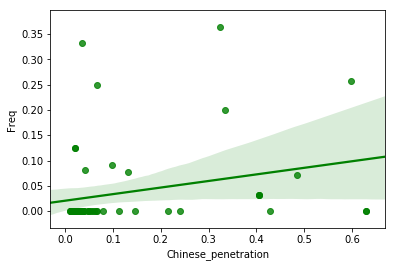

In [108]:
ax = sns.regplot(x=final_df['Chinese_penetration'], y=final_df['Freq'], color="g")

# Obviously the linear regression does not fit our model. Now we only keep the rows with a Freq great than zero

In [109]:
final_df = final_df[final_df['Freq'] > 0]
final_df

Neighbourhood      Freq  \
Neighbourhood                                                  
Agincourt North                    Agincourt North  0.071429   
Dorset Park                            Dorset Park  0.090909   
Kennedy Park                          Kennedy Park  0.250000   
L'Amoreaux West                    L'Amoreaux West  0.200000   
Lawrence Park                        Lawrence Park  0.081633   
Milliken                                  Milliken  0.256410   
Riverdale                                Riverdale  0.363636   
Scarborough Village            Scarborough Village  0.125000   
Scarborough Village West  Scarborough Village West  0.125000   
The Danforth West                The Danforth West  0.076923   
Victoria Village                  Victoria Village  0.333333   
Willowdale                              Willowdale  0.031250   
Willowdale South                  Willowdale South  0.031250   
Willowdale West                    Willowdale West  0.031250   

                          Chinese_penetration  
Neighbourhood                                  
Agincourt North                      0.485799  
Dorset Park                          0.098933  
Kennedy Park                         0.067155  
L'Amoreaux West                      0.335411  
Lawrence Park                        0.042326  
Milliken                             0.598859  
Riverdale                            0.324920  
Scarborough Village                  0.019862  
Scarborough Village West             0.019862  
The Danforth West                    0.131667  
Victoria Village                     0.035215  
Willowdale                           0.406138  
Willowdale South                     0.406138  
Willowdale West                      0.406138

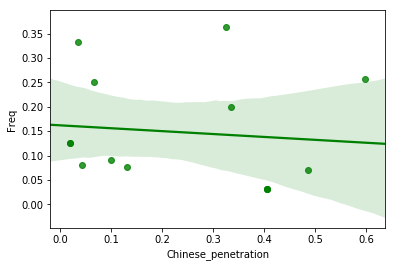

In [110]:
ax = sns.regplot(x=final_df['Chinese_penetration'], y=final_df['Freq'], color="g")

# However, the linear gression model still fails to figure out any pattern
